In [3]:
from sklearn.decomposition import PCA 
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import nltk
from enum import Enum

text_path = Path("texts/")
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize


# Testing Semantic Analysis of texts

This notebook is to verify and test different methods of semantic analysis on texts, to figure out what is best suited for visualizing the effects of models iterating upon their own outputs on the quality of such output.


## Method 1: sBERT PCA
The fist method we'll try is Principal Component Analysis using a sentence transformer(sBERT model).

### Step 1: Text embedding and scaling.

In [4]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

scaler = StandardScaler()
results = []
names = {}
for file in text_path.iterdir():
    if file.is_file() and not file.name.startswith('.'):
        print(f"\nProcessing: {file.name}")
        text = open(file).read()
        sentences = sent_tokenize(text)
        names[file.name] = len(sentences)
        for sentence in sentences:
            embeddings = sentence_model.encode(sentence)
            results.append(embeddings)
all_outputs = np.array(results)
print(all_outputs.shape)
scaled = scaler.fit_transform(all_outputs)
print(scaled.shape)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Processing: nietzsche.txt

Processing: 1984_1.txt

Processing: sanderson_1.txt

Processing: goethe_1.txt

Processing: marx_1.txt

Processing: rogers_1.txt

Processing: sapolsky_2.txt

Processing: sapolsky_1.txt
(171, 384)
(171, 384)


### Step 2: PCA Transformation
Next we run PCA on our output

In [5]:
pca = PCA(n_components=2) # setup pca for projecting down into 2d space

embeddings_2d = pca.fit_transform(scaled) # project our scaled embeddings



### Step 3: Visualization



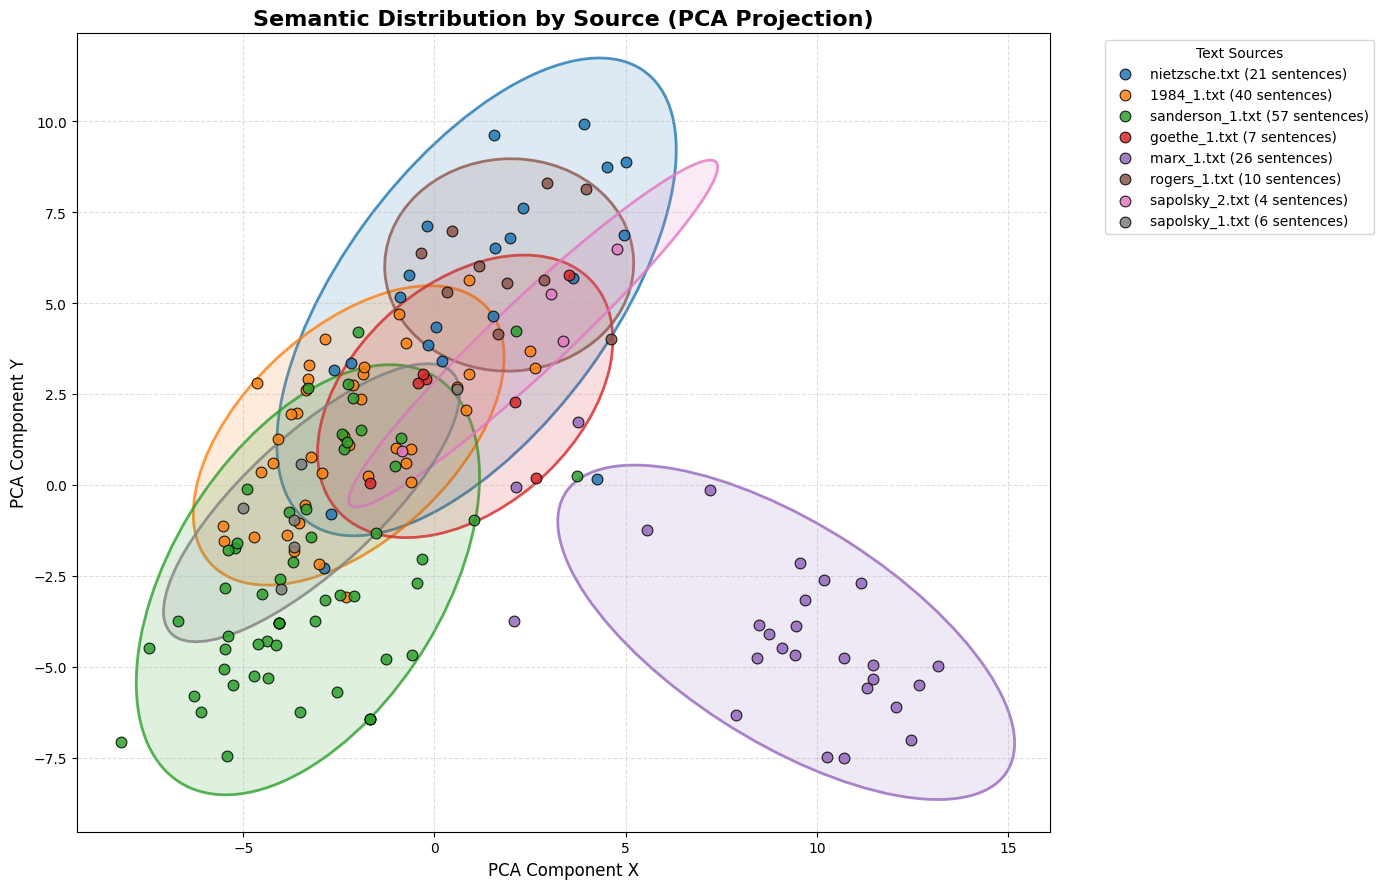

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def draw_confidence_ellipse(ax, points, color, n_std=2.0):
    """Draw an ellipse showing the distribution of points."""
    if len(points) < 3:
        return
    
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)
    lambda_, v = np.linalg.eigh(cov)
    lambda_ = np.sqrt(np.maximum(lambda_, 1e-9))
    
    angle = np.rad2deg(np.arctan2(v[1, 0], v[0, 0]))
    
    # Draw the filled area
    ellipse = Ellipse(
        xy=mean, 
        width=lambda_[0] * n_std * 2, 
        height=lambda_[1] * n_std * 2, 
        angle=angle, 
        facecolor=color, 
        alpha=0.15 
    )
    ax.add_patch(ellipse)
    
    # Draw a more distinct border
    outline = Ellipse(
        xy=mean, 
        width=lambda_[0] * n_std * 2, 
        height=lambda_[1] * n_std * 2, 
        angle=angle, 
        edgecolor=color, 
        facecolor='none', 
        alpha=0.8, 
        linestyle='-', 
        linewidth=2
    )
    ax.add_patch(outline)

# Use a much more saturated/distinct colormap for up to 10 sources
num_texts = len(names)
if num_texts <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
else:
    # Use a high-quality large distinct map if more than 10
    colors = plt.cm.nipy_spectral(np.linspace(0.1, 0.9, num_texts))

fig, ax = plt.subplots(figsize=(14, 9))

current_idx = 0
for i, (text_name, count) in enumerate(names.items()):
    indices = range(current_idx, current_idx + count)
    points = embeddings_2d[indices]
    color = colors[i % len(colors)]
    
    # Scatter points with high saturation and distinct size
    ax.scatter(
        points[:, 0], 
        points[:, 1], 
        color=color, 
        label=f"{text_name} ({count} sentences)", 
        alpha=0.85, 
        edgecolors='black', 
        linewidth=0.8,
        s=60,
        zorder=3
    )
    
    # Circle the distribution with saturated lines
    draw_confidence_ellipse(ax, points, color)
    
    current_idx += count

ax.set_title("Semantic Distribution by Source (PCA Projection)", fontsize=16, fontweight='bold')
ax.set_xlabel("PCA Component X", fontsize=12)
ax.set_ylabel("PCA Component Y", fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Text Sources", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.4, zorder=0)
plt.tight_layout()
plt.show()


## Method 2: BERT PCA

Rather than using sBERT for embedding, lets try using regular BERT instead. So rather than getting an embedding for every setence, we will get an embedding for every token. We should be able to look at the spread of all token embeddings this way. This might prove to be useful.